## Лабораторная работа №3


In [ ]:
import numpy as np
import random 
import sys
from scipy import stats
import matplotlib.pyplot as plt

N = 1000
m1 = 1
sigma1 = 3.5
m2 = 1
sigma2 = 3.5

# зависимые гауссовские выборки
def GenerateDependentGaussian(m1, sigma1, m2, sigma2, N, corr):
    X = [random.gauss(m1, sigma1) for i in range(N)]
    Z = [random.gauss(m2, sigma2) for i in range(N)]
    Y = [corr*X[i] + (1-corr)*Z[i] for i in range(N)]
    return np.array(X), np.array(Y)

# одна гауссовская выборка, другая нет, зависимость нелинейная и монотонная

def GenerateDependentNonLinearMonotonous(m1, sigma1, m2, sigma2, N):
    X = [random.gauss(m1, sigma1) for i in range(N)]
    Z = [random.gauss(m2, sigma2) for i in range(N)]
    Y = [2*np.exp(X[i] ** 2) + Z[i] for i in range(N)]
    return np.array(X), np.array(Y)
# одна гауссовская выборка, другая нет, зависимость нелинейная и немонотонная

def GenerateDependentNonLinearNonMonotonous(m1, sigma1, m2, sigma2, N):
    X = [random.gauss(m1, sigma1) for i in range(N)]
    Z = [random.gauss(m2, sigma2) for i in range(N)]
    Y = [np.sin(X[i]) + Z[i] for i in range(N)]
    return np.array(X), np.array(Y)

Превращаем признак в номинальный:

In [627]:
def TwoAttributesToNominal3(X, Y, numIntervalsX, numIntervalsY): 
    XNominal = AttributeToNominal(X, numIntervalsX)
    YNominal = AttributeToNominal(Y, numIntervalsY)
    return [XNominal, YNominal]
                
def AttributeToNominal3(X, numIntervals):
    meshX = np.linspace(min(X), max(X), numIntervals)
    XNominal = np.zeros(numIntervals)
    for xi in X: 
        for i in range(1, numIntervals, 1):
            if meshX[i-1] < xi and xi <= meshX[i]:
                XNominal[i-1] += 1
    return XNominal

In [628]:
def TwoAttributesToNominal2(X, Y, numIntervalsX, numIntervalsY):
    contTable = np.zeros((numIntervalsX, numIntervalsY))
    meshX = np.linspace(min(X), max(X), numIntervalsX)
    meshY = np.linspace(min(Y), max(Y), numIntervalsY)
    
    i = 0
    for xi in X:
        j = 0
        for yj in Y:
            if (meshX[i-1] < xi and xi <= meshX[i]) and (meshY[j-1] < yj and yj <= meshY[j]):
                contTable[i-1, j-1] += 1
            j+=1
            if j > 4: 
                break
        i+=1
        if i > 4: 
            break
    contTable[numIntervalsX - 1][numIntervalsY - 1] += 1;
    return contTable;

In [640]:
def TwoAttributesToNominal(X, Y, N = 100): 
    x_step = (max(X) - min(X))/N
    y_step = (max(Y) - min(Y))/N
    x = min(X)
    n = len(X)
    cont_table = []
    while x < max(X):
        row = []
        y = min(Y)
        while y < max(Y) - y_step:
            count = 0
            for i in range(n):
                if (X[i] >= x) & (X[i] < x + x_step) & (Y[i] >= y) & (Y[i] < y + y_step):
                    count+=1
            row.append(count)
            y += y_step
        cont_table.append(row)
        x += x_step
    #cont_table[N-1][N-1] += 1
    return np.array(cont_table)

### Критерий хи-квадрат (Фишера-Пирсона)

In [630]:
def HiSquare(contTable, N, alpha):
    sumTotal = 0
    #print(contTable)
    for i in range(contTable.shape[0]):
        for j in range(contTable.shape[1]):
            sumNdotJ = np.sum(contTable, axis = 0)[j]
            sumNIdot = np.sum(contTable, axis = 1)[i]
            sumTotal += ((contTable[i, j] - (sumNIdot * sumNdotJ) / N) ** 2) / ((sumNIdot * sumNdotJ) / N)
            pValue = 1 - stats.chi2.cdf(sumTotal, (contTable.shape[0] - 1) *(contTable.shape[1] - 1))
            #print(pValue)
            if pValue > alpha:
                complete = 0
            else:
                complete = 1
            return complete
    

In [631]:
HiSquare(TwoAttributesToNominal(X1, Y1, 5), 1000, 0.95)

NameError: name 'X1' is not defined

### Выборочный коэфициент корреляции

In [632]:
def SampleCorrelationCoefficient(X, Y, alpha):
    xMean = np.mean(X, dtype = np.float64)
    yMean = np.mean(Y, dtype = np.float64)
    N = X.shape[0]
    
    numerator = 0
    xDenominator = 0
    yDenominator = 0
    
    for i in range(N):
        numerator += (X[i] - xMean) * (Y[i] - yMean)
        xDenominator += (X[i] - xMean) ** 2
        yDenominator += (Y[i] - yMean) ** 2
        
    numerator *= (1/N) 
    xDenominator *= (1/N)
    yDenominator *= (1/N)
    
    rXY = numerator / (np.sqrt(xDenominator * yDenominator))
    testStat = np.sqrt(N)*rXY
    pVal = min(2*stats.norm.cdf(testStat), 2 - 2*stats.norm.cdf(testStat))
    #print(pVal)
    if (pVal > alpha / 2) and (pVal < (1 - alpha / 2)):
        complete = 0
    else:
        complete = 1
    return complete
        

In [633]:
X, Y = GenerateDependentGaussian(m1, sigma1, m2, sigma2, N)
SampleCorrelationCoefficient(X, Y, 0.05)

TypeError: GenerateDependentGaussian() missing 1 required positional argument: 'corr'

In [634]:
#ранжирование простое тк вероятность получения дубликатов == 0 

def RankOrder(X):
    X1 = X.copy()
    ranked = np.zeros(X1.shape[0])
    temp = np.amax(X1) + 1
    for i in range(X1.shape[0]):
        minX = np.amin(X1)
        for j in range(X1.shape[0]):
            if X1[j] == minX:
                ranked[j] = i + 1
                X1[j] = temp
                break;
    return ranked

In [635]:
def Spearman(X, Y, alpha):
    XRanked = RankOrder(X)
    YRanked = RankOrder(Y)
    if (XRanked.shape[0] != YRanked.shape[0]):
        print("Вероятность этого была == 0 но дубликаты таки попались")
        return 0;
     
    N = XRanked.shape[0]
    sumSquares = 0
    for i in range(N):
        sumSquares += (XRanked[i] - YRanked[i]) ** 2
    ro = 1 - (6*sumSquares)/(N ** 3 - N)
    testStat = np.sqrt(N-1) * ro
    
    pVal = min(2*stats.norm.cdf(testStat), 2 - 2*stats.norm.cdf(testStat))
    #print(pVal)
    if (pVal > alpha / 2) and (pVal < (1 - alpha / 2)):
        complete = 0
    else:
        complete = 1
    return complete
        

In [636]:
N = 1000
m1 = 1
sigma1 = 3.5
m2 = 1
sigma2 = 3.5
alpha = 0
numExperiments = 200

sumCorr = 0;
for i in range(numExperiments):
    X, Y = GenerateDependentGaussian(m1, sigma1, m2, sigma2, N)
    contTable = TwoAttributesToNominal(X, Y, 5)
    sumCorr += HiSquare(contTable, N, alpha)
        
print(sumCorr)

TypeError: GenerateDependentGaussian() missing 1 required positional argument: 'corr'

In [637]:
for i in range(numExperiments):
    X, Y = GenerateDependentNonLinearMonotonous(m1, sigma1, m2, sigma2, N)

In [654]:
numExperiments = 200
N = 1000
m1 = 1
sigma1 = 0.01
m2 = 1
sigma2 = 0.01
alpha = 0.05
corr = 0.3


In [655]:
sumSpearman = 0
sumHiSquare = 0
sumCorr = 0
for i in range(numExperiments):
    print(i)
    X, Y = GenerateDependentGaussian(m1, sigma1, m2, sigma2, N, corr)
    sumSpearman += Spearman(X, Y, alpha)
    sumHiSquare += HiSquare(TwoAttributesToNominal(X, Y), N, alpha)
    sumCorr += SampleCorrelationCoefficient(X, Y, alpha)
print('Spearman: ', numExperiments - sumSpearman)
print('HiSquare: ', numExperiments - sumHiSquare)
print('Corr: ', numExperiments - sumCorr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Spearman:  0
HiSquare:  193
Corr:  0


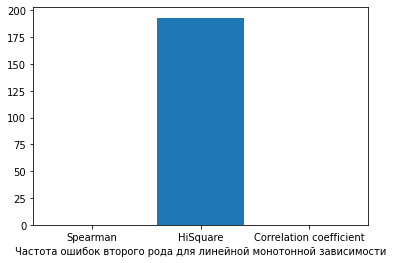

In [656]:
Values = [numExperiments - sumSpearman, numExperiments - sumHiSquare, numExperiments - sumCorr]
Names = ['Spearman', 'HiSquare', 'Correlation coefficient']
plt.bar(Names, Values)
plt.xlabel('Частота ошибок второго рода для линейной монотонной зависимости')
plt.show()

In [645]:
sumSpearman = 0
sumHiSquare = 0
sumCorr = 0
for i in range(numExperiments):
    print(i)
    X, Y = GenerateDependentNonLinearMonotonous(m1, sigma1, m2, sigma2, N)
    sumSpearman += Spearman(X, Y, alpha)
    sumHiSquare += HiSquare(TwoAttributesToNominal(X, Y), N, alpha)
    sumCorr += SampleCorrelationCoefficient(X, Y, alpha)
print('Spearman: ', numExperiments - sumSpearman)
print('HiSquare: ', numExperiments - sumHiSquare)
print('Corr: ', numExperiments - sumCorr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Spearman:  0
HiSquare:  0
Corr:  0


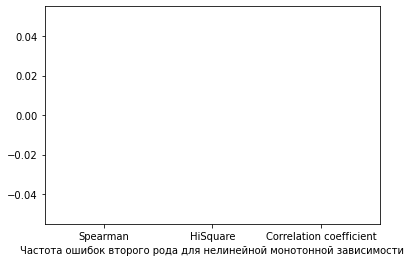

In [648]:
Values = [numExperiments - sumSpearman, numExperiments - sumHiSquare, numExperiments - sumCorr]
Names = ['Spearman', 'HiSquare', 'Correlation coefficient']
plt.bar(Names, Values)
plt.xlabel('Частота ошибок второго рода для нелинейной монотонной зависимости')
plt.show()

In [650]:
sumSpearman = 0
sumHiSquare = 0
sumCorr = 0
for i in range(numExperiments):
    print(i)
    X, Y = GenerateDependentNonLinearNonMonotonous(m1, sigma1, m2, sigma2, N)
    sumSpearman += Spearman(X, Y, alpha)
    sumHiSquare += HiSquare(TwoAttributesToNominal(X, Y), N, alpha)
    sumCorr += SampleCorrelationCoefficient(X, Y, alpha)
print('Spearman: ', numExperiments - sumSpearman)
print('HiSquare: ', numExperiments - sumHiSquare)
print('Corr: ', numExperiments - sumCorr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Spearman:  194
HiSquare:  199
Corr:  193


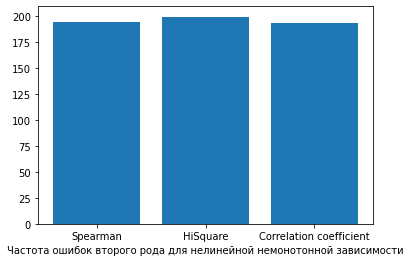

In [651]:
Values = [numExperiments - sumSpearman, numExperiments - sumHiSquare, numExperiments - sumCorr]
Names = ['Spearman', 'HiSquare', 'Correlation coefficient']
plt.bar(Names, Values)
plt.xlabel('Частота ошибок второго рода для нелинейной немонотонной зависимости')
plt.show()